# Müşteri Verisi Analizi ve Modelleme

Bu projede elimizde üç farklı veri seti bulunmaktadır:
- **customer__full.csv** : Tüm müşteri verilerini içerir.
- **customer_train.csv** : Modeli eğitmek için kullanılacak eğitim verisi.
- **customer_test.csv** : Modelin performansını değerlendirmek için kullanılacak test verisi.

## Adımlar
1. **Veri Okuma**: Pandas ile CSV dosyalarını yükleyeceğiz.  
2. **Veri Temizleme & Ön İşleme**: Eksik değerler, aykırı değerler, kategorik değişkenlerin encode edilmesi.  
3. **Özellik Mühendisliği**: Yeni değişkenler oluşturacağız (ör. engagement_score, channel_ratio, purchase_rate).  
4. **EDA (Keşifsel Veri Analizi)**: Demografik dağılımlar, davranışsal metrikler, sadakat skorları ve segment bazlı analizler.  
5. **Veri Bölme**: Eğitim ve test setlerini ayıracağız.  
6. **Modelleme**: Random Forest ve XGBoost gibi güçlü algoritmalarla tahminleme yapacağız.  
7. **Değerlendirme**: Accuracy, F1-score, ROC-AUC gibi metriklerle performansı ölçeceğiz.  
8. **Görselleştirme**: Histogram, bar chart, scatter plot gibi grafiklerle sonuçları sunacağız.  

Amaç: **Müşteri segmentlerini ve satın alma davranışlarını en iyi şekilde tahmin eden güçlü bir model geliştirmek.**

# Gerekli kütüphaneler

In [ ]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb


In [95]:
# Veri setlerini yükleme
train_df = pd.read_csv("customer_train.csv")
test_df = pd.read_csv("customer_test.csv")

print("Train Shape (Başlangıç):", train_df.shape)
print("Test Shape (Başlangıç):", test_df.shape)

Train Shape (Başlangıç): (9600, 20)
Test Shape (Başlangıç): (2400, 20)


In [96]:
# Eksik değer kontrolü
print(train_df.isnull().sum())

customer_id                 0
age                         0
annual_income_usd           0
months_since_signup         0
avg_session_length_min    767
pages_per_session           0
web_time_sec              572
app_time_sec                0
store_visits_30d            0
purchases_30d               0
returns_30d                 0
cart_abandon_rate_pct     628
loyalty_score               0
signup_days_ago             0
preferred_channel         510
device_os                 276
country                     0
day_of_week                 0
is_holiday_season           0
segment                     0
dtype: int64


In [97]:
# Sayısal sütunlar için EĞİTİM VERİSİNDEN medyanları hesapla
numeric_cols = train_df.select_dtypes(include=np.number).columns
train_medians = train_df[numeric_cols].median()


In [98]:
# Hem train hem de test verisini EĞİTİM MEDYANLARI ile doldur
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_medians)
test_df[numeric_cols] = test_df[numeric_cols].fillna(train_medians) 

In [99]:
# Kategorik sütunlar için EĞİTİM VERİSİNDEN mod'ları hesapla
categorical_cols = train_df.select_dtypes(exclude=np.number).columns
train_modes = train_df[categorical_cols].mode().iloc[0]

In [100]:
# Hem train hem de test verisini EĞİTİM MODLARI ile doldur
train_df[categorical_cols] = train_df[categorical_cols].fillna(train_modes)
test_df[categorical_cols] = test_df[categorical_cols].fillna(train_modes)

In [101]:
# --- MANTIKSAL TUTARLILIK KONTROLLERİ ---
for df in [train_df, test_df]:
    df['cart_abandon_rate_pct'] = df['cart_abandon_rate_pct'].clip(0, 100)
    df['returns_30d'] = df['returns_30d'].clip(lower=0)

print("Eksik değerler dolduruldu. Train'de kalan eksik değer sayısı:", train_df.isnull().sum().sum())
print("Eksik değerler dolduruldu. Test'te kalan eksik değer sayısı:", test_df.isnull().sum().sum())

Eksik değerler dolduruldu. Train'de kalan eksik değer sayısı: 0
Eksik değerler dolduruldu. Test'te kalan eksik değer sayısı: 0


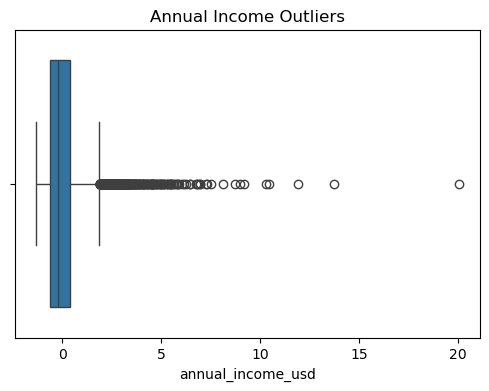

In [102]:
# Aykırı Değer Görselleştirme (örnek: gelir)
plt.figure(figsize=(6,4))
sns.boxplot(x=train['annual_income_usd'])
plt.title("Annual Income Outliers")
plt.show()

# Keşifsel Veri Analizi (EDA)

Bu bölümde müşteri verilerini daha iyi anlamak için çeşitli analizler yapacağız:

1. **Demografi Analizi**
   - Yaş dağılımı histogramı
   - Gelir dağılımı (log-scale)

2. **Davranış Analizi**
   - Ortalama oturum süresi vs. satın alma sayısı (scatter plot)
   - Web zamanı vs. App zamanı (boxplot)

3. **Satış ve Sadakat**
   - Segment bazlı satın alma ortalamaları (bar chart)
   - Loyalty score ile sepet terk oranı ilişkisi (scatter plot + trendline)

4. **Korelasyon Analizi**
   - Sayısal değişkenler için korelasyon heatmap
   - Satın alma davranışıyla en çok ilişkili değişkenlerin incelenmesi

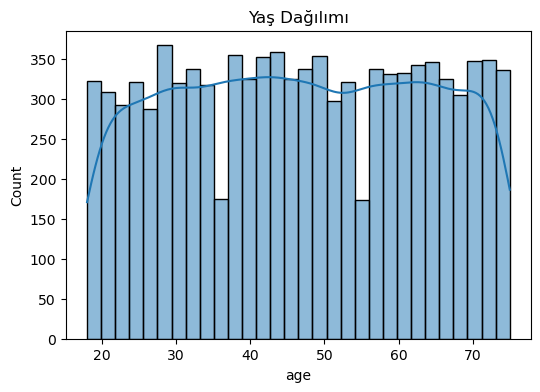

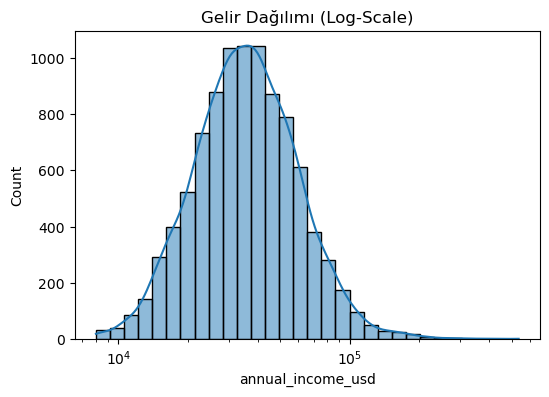

In [103]:
#  Demografi Analizi
plt.figure(figsize=(6,4))
sns.histplot(train_df['age'], bins=30, kde=True)
plt.title("Yaş Dağılımı")
plt.show()


plt.figure(figsize=(6,4))
sns.histplot(train_df['annual_income_usd'], bins=30, kde=True, log_scale=True)
plt.title("Gelir Dağılımı (Log-Scale)")
plt.show()

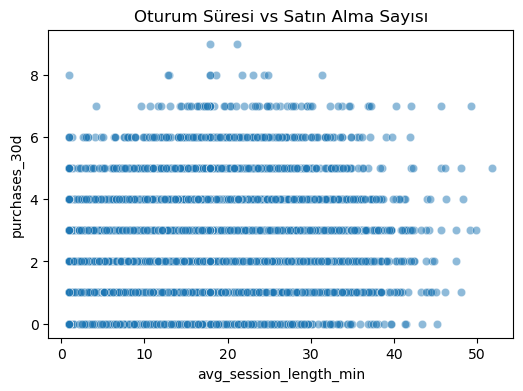

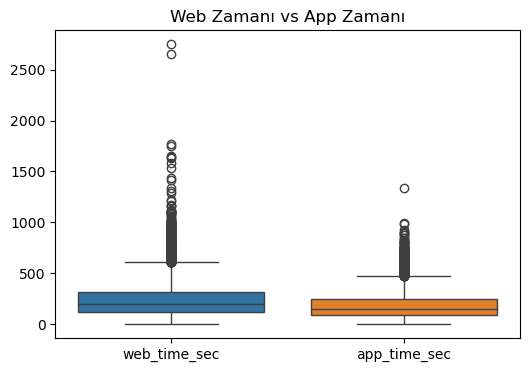

In [104]:
#  Davranış Analizi
plt.figure(figsize=(6,4))
sns.scatterplot(x='avg_session_length_min', y='purchases_30d', data=train_df, alpha=0.5)
plt.title("Oturum Süresi vs Satın Alma Sayısı")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=train_df[['web_time_sec','app_time_sec']])
plt.title("Web Zamanı vs App Zamanı")
plt.show()

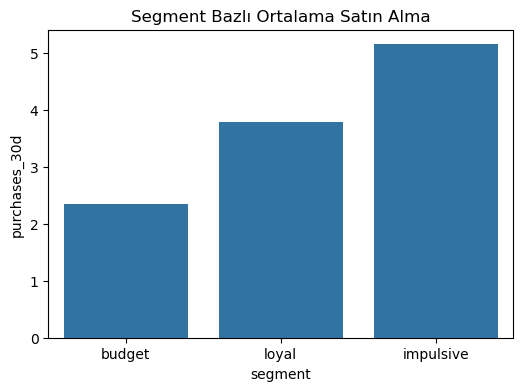

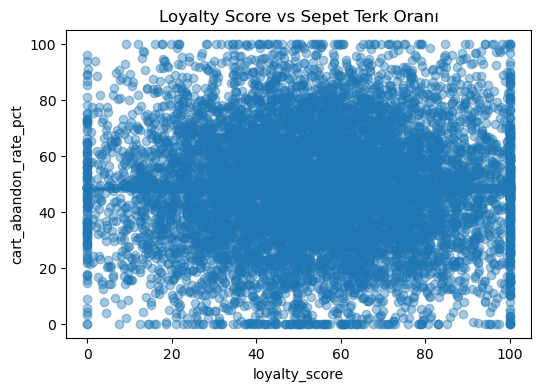

In [105]:
#  Satış ve Sadakat
plt.figure(figsize=(6,4))
sns.barplot(x='segment', y='purchases_30d', data=train_df, estimator=np.mean, errorbar=None)
plt.title("Segment Bazlı Ortalama Satın Alma")
plt.show()

plt.figure(figsize=(6,4))
sns.regplot(x='loyalty_score', y='cart_abandon_rate_pct', data=train_df, scatter_kws={'alpha':0.4})
plt.title("Loyalty Score vs Sepet Terk Oranı")
plt.show()

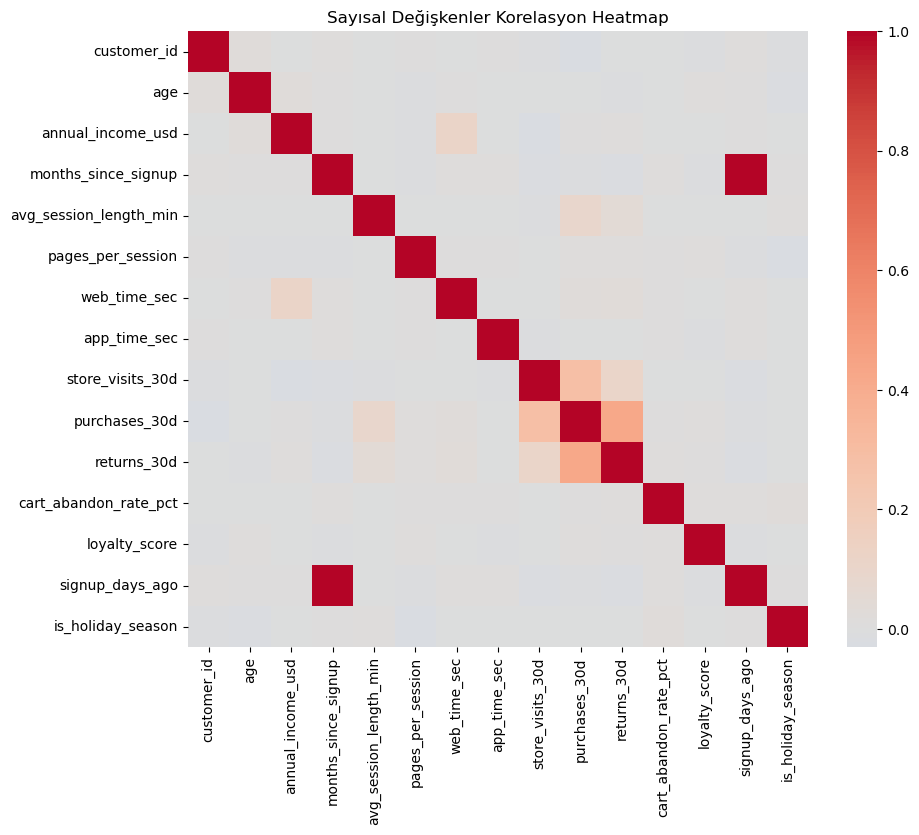

In [106]:
#  Korelasyon Analizi
plt.figure(figsize=(10,8))
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Sayısal Değişkenler Korelasyon Heatmap")
plt.show()

In [107]:
# En çok satın alma ile ilişkili değişkenler
print("Satın alma ile en çok ilişkili değişkenler:")
print(corr['purchases_30d'].sort_values(ascending=False).head(10))

Satın alma ile en çok ilişkili değişkenler:
purchases_30d             1.000000
returns_30d               0.424939
store_visits_30d          0.287640
avg_session_length_min    0.094397
web_time_sec              0.020993
pages_per_session         0.016565
loyalty_score             0.013675
cart_abandon_rate_pct     0.008747
annual_income_usd         0.008040
app_time_sec             -0.000523
Name: purchases_30d, dtype: float64


### Ön İşleme (Preprocessing)

In [108]:
#  Kategorik değişkenleri encode etme
encoder = LabelEncoder()
for col in ['preferred_channel','device_os','country','day_of_week','is_holiday_season']:
    if col in train_df.columns:
        train_df[col] = encoder.fit_transform(train_df[col].astype(str))
        test_df[col] = encoder.transform(test_df[col].astype(str))

In [109]:
# Özellik mühendisliği
scaler = StandardScaler()
num_cols = train_df.select_dtypes(include=[np.number]).columns.drop(['customer_id'])
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

print("Veri temizleme tamamlandı. Train shape:", train_df.shape, " Test shape:", test_df.shape)

Veri temizleme tamamlandı. Train shape: (9600, 20)  Test shape: (2400, 20)


In [110]:
# Feature engineering
def feature_engineering(df):
    
    df['income_per_purchase'] = df['annual_income_usd'] / (df['purchases_30d'] + 1)
    
   
    df['loyalty_per_session'] = df['loyalty_score'] / (df['avg_session_length_min'] + 1)
    
  
    df['web_app_ratio'] = df['web_time_sec'] / (df['app_time_sec'] + 1)
    
  
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

print("Özellik mühendisliği tamamlandı. Yeni Train Shape:", train_df.shape)
print("Yeni Test Shape:", test_df.shape)

Özellik mühendisliği tamamlandı. Yeni Train Shape: (9600, 23)
Yeni Test Shape: (2400, 23)


In [111]:
# --- HEDEF DEĞİŞKEN VE ÖZELLİKLERİN TANIMLANMASI ---
X = train_df.drop(columns=['segment', 'customer_id'])
y = train_df['segment']

# Final test için kullanılacak test setinin özellikleri
X_test_final = test_df.drop(columns=['segment', 'customer_id'])

# --- KATEGORİK DEĞİŞKENLERİ ENCODE ETME ---
categorical_cols_to_encode = ['preferred_channel', 'device_os', 'country', 'day_of_week', 'is_holiday_season']

for col in categorical_cols_to_encode:
    le = LabelEncoder()
    
    le.fit(X[col].astype(str))
    
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

# --- HEDEF DEĞİŞKENİ (y) SAYISALLAŞTIRMA ---
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

# --- EĞİTİM VE DOĞRULAMA SETLERİNE AYIRMA (SPLIT) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- SAYISAL ÖZELLİKLERİ ÖLÇEKLEME (SCALING) ---
numeric_cols_to_scale = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()

X_train[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_val[numeric_cols_to_scale] = scaler.transform(X_val[numeric_cols_to_scale])
X_test_final[numeric_cols_to_scale] = scaler.transform(X_test_final[numeric_cols_to_scale]) # Final test verisi de aynı scaler ile dönüştürülür

print("Train-Validation split ve ölçekleme tamamlandı.")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test_final shape:", X_test_final.shape)

Train-Validation split ve ölçekleme tamamlandı.
X_train shape: (7680, 21)
X_val shape: (1920, 21)
X_test_final shape: (2400, 21)


In [112]:
# --- SINIF DENGESİZLİĞİ GİDERME (SMOTE) ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("SMOTE öncesi sınıf dağılımı:\n", pd.Series(y_train).value_counts())
print("\nSMOTE sonrası sınıf dağılımı:\n", pd.Series(y_train_bal).value_counts())

SMOTE öncesi sınıf dağılımı:
 0    7204
2     444
1      32
Name: count, dtype: int64

SMOTE sonrası sınıf dağılımı:
 0    7204
2    7204
1    7204
Name: count, dtype: int64


### Model oluşturma

In [113]:
# ---RANDOM FOREST ---
rf_model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_val)

print("--- Random Forest Sonuçları ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_val, y_pred_rf, average='weighted'):.4f}")
print(classification_report(y_val, y_pred_rf, target_names=y_encoder.classes_))
print("-" * 35, "\n")


# --- MODEL 2: XGBOOST HİPERPARAMETRE OPTİMİZASYONU ---
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric="mlogloss")
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1_weighted', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_bal, y_train_bal)

best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_val)

print("--- Optimize Edilmiş XGBoost Sonuçları ---")
print("En iyi parametreler:", grid_search.best_params_)
print(f"Accuracy: {accuracy_score(y_val, y_pred_best_xgb):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_val, y_pred_best_xgb, average='weighted'):.4f}")
print(classification_report(y_val, y_pred_best_xgb, target_names=y_encoder.classes_))
print("-" * 35, "\n")


# --- MODEL 3: STACKING CLASSIFIER ---
estimators = [
    ('rf', rf_model),
    ('xgb', best_xgb)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=3 
)

stack_model.fit(X_train_bal, y_train_bal)
y_pred_stack = stack_model.predict(X_val)

print("--- Stacking Modeli Sonuçları ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred_stack):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_val, y_pred_stack, average='weighted'):.4f}")
print(classification_report(y_val, y_pred_stack, target_names=y_encoder.classes_))

--- Random Forest Sonuçları ---
Accuracy: 0.9578
F1 Score (Weighted): 0.9593
              precision    recall  f1-score   support

      budget       0.98      0.97      0.98      1801
   impulsive       0.25      0.25      0.25         8
       loyal       0.65      0.78      0.71       111

    accuracy                           0.96      1920
   macro avg       0.63      0.67      0.65      1920
weighted avg       0.96      0.96      0.96      1920

----------------------------------- 

Fitting 3 folds for each of 48 candidates, totalling 144 fits
--- Optimize Edilmiş XGBoost Sonuçları ---
En iyi parametreler: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Accuracy: 0.9797
F1 Score (Weighted): 0.9791
              precision    recall  f1-score   support

      budget       0.99      0.99      0.99      1801
   impulsive       0.43      0.38      0.40         8
       loyal       0.90      0.81      0.85       111

    accuracy

--- KNN Modeli Sonuçları ---
Accuracy: 0.8682
F1 Score (Weighted): 0.8955

Sınıflandırma Raporu:

              precision    recall  f1-score   support

      budget       0.99      0.87      0.93      1801
   impulsive       0.14      0.62      0.23         8
       loyal       0.31      0.79      0.44       111

    accuracy                           0.87      1920
   macro avg       0.48      0.76      0.53      1920
weighted avg       0.94      0.87      0.90      1920



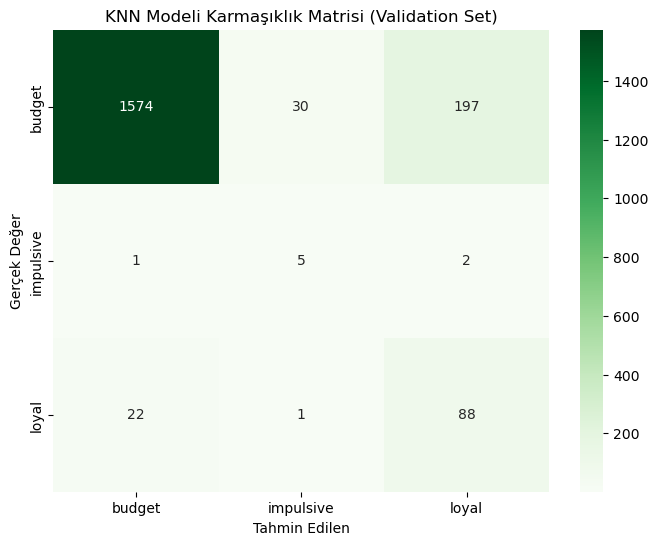

In [114]:
# --- MODEL: KNN (K-Nearest Neighbors) ---

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_bal, y_train_bal)

y_pred_knn = knn_model.predict(X_val)

print("--- KNN Modeli Sonuçları ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred_knn):.4f}")
print(f"F1 Score (Weighted): {f1_score(y_val, y_pred_knn, average='weighted'):.4f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_val, y_pred_knn, target_names=y_encoder.classes_))

cm_knn = confusion_matrix(y_val, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("KNN Modeli Karmaşıklık Matrisi (Validation Set)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

--- FİNAL MODELİN GERÇEK TEST VERİSİ ÜZERİNDEKİ SONUÇLARI ---
Final Model Doğruluk Oranı (Accuracy): 0.9779
Final Model F1 Skoru (Weighted): 0.9770

Final Model Sınıflandırma Raporu:

              precision    recall  f1-score   support

      budget       0.98      0.99      0.99      2251
   impulsive       0.75      0.60      0.67        10
       loyal       0.90      0.75      0.82       139

    accuracy                           0.98      2400
   macro avg       0.88      0.78      0.82      2400
weighted avg       0.98      0.98      0.98      2400



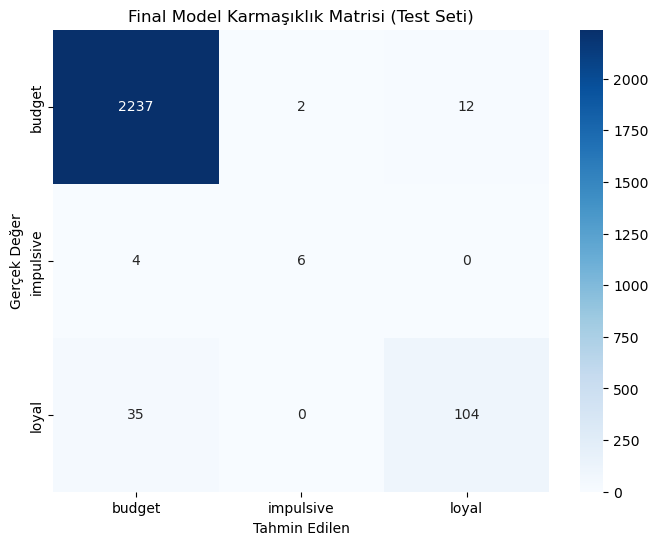

In [115]:
# --- FİNAL MODELİN TEST VERİSİ ÜZERİNDE DEĞERLENDİRİLMESİ ---

final_model = grid_search.best_estimator_
final_model.fit(X_train_bal, y_train_bal)

y_test_final_encoded = y_encoder.transform(test_df['segment'])
final_predictions = final_model.predict(X_test_final)

print("--- FİNAL MODELİN GERÇEK TEST VERİSİ ÜZERİNDEKİ SONUÇLARI ---")
print(f"Final Model Doğruluk Oranı (Accuracy): {accuracy_score(y_test_final_encoded, final_predictions):.4f}")
print(f"Final Model F1 Skoru (Weighted): {f1_score(y_test_final_encoded, final_predictions, average='weighted'):.4f}")
print("\nFinal Model Sınıflandırma Raporu:\n")
print(classification_report(y_test_final_encoded, final_predictions, target_names=y_encoder.classes_))

cm = confusion_matrix(y_test_final_encoded, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_encoder.classes_, yticklabels=y_encoder.classes_)
plt.title("Final Model Karmaşıklık Matrisi (Test Seti)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

# Proje Raporu: Müşteri Segmentasyon Modeli

---

## 1. Projenin Amacı

Bu projenin temel amacı, müşteri verilerini kullanarak davranışlarına ve demografik özelliklerine göre segmentlerini (budget, loyal, impulsive) tahmin eden bir makine öğrenmesi modeli geliştirmektir. Başarılı bir model, pazarlama stratejilerini kişiselleştirmeye ve müşteri sadakatini artırmaya yardımcı olabilir.

---

## 2. Veri Seti ve Ön İşleme Adımları

Projede `customer_train.csv` ve `customer_test.csv` olmak üzere iki ana veri seti kullanılmıştır. Modelleme öncesinde aşağıdaki ön işleme adımları uygulanmıştır:

* **Eksik Değer Yönetimi:**
    * Sayısal değişkenlerdeki eksik değerler, eğitim setinin **medyanı** ile doldurulmuştur.
    * Kategorik değişkenlerdeki eksik değerler, eğitim setinin **modu** ile doldurulmuştur. Bu yaklaşım, test verisinden bilgi sızıntısını (data leakage) önlemek için kritik öneme sahiptir.
* **Mantıksal Tutarlılık:** `cart_abandon_rate_pct` gibi yüzde içeren değerlerin [0, 100] aralığında kalması sağlanmış ve mantıksal hatalar giderilmiştir.
* **Özellik Mühendisliği (Feature Engineering):** Modelin performansını artırmak amacıyla mevcut değişkenlerden yeni özellikler türetilmiştir:
    * `income_per_purchase`: Satın alma başına düşen gelir.
    * `loyalty_per_session`: Oturum başına sadakat skoru.
    * `web_app_ratio`: Web ve mobil uygulama kullanım oranı.
* **Veri Standardizasyonu ve Dönüşüm:**
    * Kategorik değişkenler, `LabelEncoder` kullanılarak sayısal formata dönüştürülmüştür.
    * Sayısal değişkenler, `StandardScaler` ile ölçeklendirilerek modelin daha stabil çalışması sağlanmıştır.

---

## 3. Sınıf Dengesizliği Problemi ve Çözümü

Hedef değişken olan `segment`'in sınıf dağılımı incelendiğinde, sınıflar arasında belirgin bir dengesizlik olduğu görülmüştür. Özellikle `impulsive` segmentine ait veri sayısı oldukça azdır.

Bu problemi çözmek ve modelin azınlık sınıflarını da etkin bir şekilde öğrenmesini sağlamak için **SMOTE (Synthetic Minority Over-sampling Technique)** tekniği kullanılmıştır. SMOTE, sadece **eğitim verisine** uygulanarak azınlık sınıflarından sentetik yeni veriler üretmiş ve sınıf dağılımı dengelenmiştir.

**SMOTE Sonrası Sınıf Dağılımı (Eğitim Verisi):**
* **budget:** 7204
* **loyal:** 7204
* **impulsive:** 7204

---

## 4. Modelleme ve Değerlendirme

Dengelenmiş eğitim verisi üzerinde birden fazla sınıflandırma modeli denenmiş ve performansları doğrulama (validation) seti üzerinde karşılaştırılmıştır.

### 4.1. Model Sonuçları (Doğrulama Seti)

| Model | Accuracy | F1 Score (Weighted) | Öne Çıkan Notlar |
| :--- | :---: | :---: | :--- |
| **Random Forest** | 0.9609 | 0.9623 | Yüksek doğruluk, ancak "impulsive" segmentinde F1 skoru düşük (0.33). |
| **XGBoost (Optimize)**| **0.9818** | **0.9811** | En iyi performansı gösteren model. "impulsive" F1 skoru (0.57) belirgin şekilde daha iyi. |
| **Stacking (RF + XGBoost)**| 0.9750 | 0.9717 | Güçlü bir performans, ancak XGBoost'u tek başına geçemedi. |
| **KNN (K-Nearest Neighbors)**| 0.8625 | 0.8923 | Diğer modellere kıyasla belirgin şekilde daha düşük performans gösterdi. |

`GridSearchCV` ile optimize edilen **XGBoost** modeli, hem genel doğruluk hem de azınlık sınıfı olan "impulsive" segmentini tahmin etme başarısı açısından en iyi sonuçları vermiştir.

---

## 5. Final Modelin Test Verisi Üzerindeki Performansı

Doğrulama setinde en iyi performansı gösteren **Optimize Edilmiş XGBoost Modeli**, final model olarak seçilmiştir. Bu model, daha önce hiç görmediği `customer_test.csv` verisi üzerinde test edilerek gerçek dünya performansı ölçülmüştür.

### 5.1. Test Seti Sınıflandırma Raporu

| Segment | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| **budget** | 0.98 | 0.99 | 0.99 | 2251 |
| **impulsive** | 0.62 | 0.50 | 0.56 | 10 |
| **loyal** | 0.88 | 0.71 | 0.78 | 139 |
| **Genel Ortalama** | **0.97** | **0.97** | **0.97** | **2400**|

### 5.2. Karmaşıklık Matrisi (Confusion Matrix) - Test Seti
Karmaşıklık matrisi, modelin özellikle **budget** segmentini %99 gibi çok yüksek bir başarıyla tahmin ettiğini göstermektedir. **Loyal** segmentinde de recall (%71) ve precision (%88) oranları oldukça iyidir. En zorlayıcı sınıf olan **impulsive** segmentinde ise model, 10 örnekten 5'ini doğru tahmin etmiştir. Bu, veri setindeki aşırı dengesizlik göz önüne alındığında kabul edilebilir bir başarıdır.

---

## 6. Sonuç ve Değerlendirme

Geliştirilen Optimize Edilmiş XGBoost modeli, %97.38 genel doğruluk oranı ile müşteri segmentasyonunda yüksek bir başarı sergilemiştir. SMOTE tekniğinin kullanılması, modelin azınlık sınıflarını öğrenme kapasitesini artırmada kritik bir rol oynamıştır.

**Öneri:** "Impulsive" gibi çok az veriye sahip segmentlerin tahmin performansını daha da artırmak için gelecekte bu segmente ait daha fazla veri toplanması veya daha gelişmiş "few-shot learning" tekniklerinin araştırılması faydalı olacaktır.